# KE5006 Applied Research

### Identifying enhancers and their strength with deep neural networks

# Preliminary Layer 1 Model

## Load libraries

In [1]:
# Set the working directory (which contains the directories source, data, etc.)
import os
os.chdir(os.path.join(os.path.sep, 'home', 'tkokkeng', 'Documents', 'KE5006-AppliedResearch', 'enhancer'))
os.getcwd()

'/home/tkokkeng/Documents/KE5006-AppliedResearch/enhancer'

In [2]:
# Check if the directory containing the source files are in the path.
import sys
if os.path.join(os.getcwd(), 'source') not in sys.path:
    sys.path.append(os.path.join(os.getcwd(), 'source'))
sys.path

['/home/tkokkeng/Documents/KE5006-AppliedResearch/enhancer',
 '',
 '/home/tkokkeng/python/python367/tsfvenv/lib/python3.6/site-packages',
 '/home/tkokkeng/Documents/KE5006-AppliedResearch/enhancer/source',
 '/home/tkokkeng/python/python367/tsfvenv/lib/python36.zip',
 '/home/tkokkeng/python/python367/tsfvenv/lib/python3.6',
 '/home/tkokkeng/python/python367/tsfvenv/lib/python3.6/lib-dynload',
 '/usr/lib/python3.6',
 '/usr/local/lib/python3.6/dist-packages',
 '/usr/lib/python3/dist-packages',
 '/home/tkokkeng/python/python367/tsfvenv/lib/python3.6/site-packages/IPython/extensions',
 '/home/tkokkeng/.ipython']

In [3]:
%matplotlib inline

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import datetime

import myUtilities as mu

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split

from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

Using TensorFlow backend.


## Load data

In [4]:
enhancer_df = pd.read_csv(os.path.join('data', 'enhancer.csv'))
enhancer_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1484 entries, 0 to 1483
Data columns (total 2 columns):
id          1484 non-null object
sequence    1484 non-null object
dtypes: object(2)
memory usage: 23.3+ KB


In [5]:
enhancer_df['enhancer'] = np.ones((len(enhancer_df),))

In [6]:
enhancer_df.head()

,id,sequence,enhancer
0,CHRX_48897056_48897256,CACAATGTAGAAGCAGAGACACAGGAACCAGGCTTGGTGATGGCTC...,1.0
1,CHR12_6444339_6444539,GCCCTCACATTCCCTGGCCCATCCCCTCCACCTCAAAATTTACAAA...,1.0
2,CHR12_6444939_6445139,GAGCAGGAGGCCAGTCACCCTGAGTCAGCCACGGGGAGACGCTGCA...,1.0
3,CHR12_6445139_6445339,CCTCTGCTGAGAACAGGACTGGGGCTTCCAGGGCAACAGGAAGGGT...,1.0
4,CHR12_6445339_6445539,ACAGCCTTAAAGGGAGCTTTTCAGGGACCTCTGGCCAGTGGGGGAT...,1.0


In [7]:
non_enhancer_df = pd.read_csv(os.path.join('data', 'non_enhancer.csv'))
non_enhancer_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1484 entries, 0 to 1483
Data columns (total 2 columns):
id          1484 non-null object
sequence    1484 non-null object
dtypes: object(2)
memory usage: 23.3+ KB


In [8]:
non_enhancer_df['enhancer'] = np.zeros((len(non_enhancer_df),))

In [9]:
non_enhancer_df.head()

,id,sequence,enhancer
0,CHRX_2970600_2970800,CAGTCACATCTGTAATCACAATACGTTGGGAGGCTGAGGCAGGAGG...,0.0
1,CHRX_6179400_6179600,ACTTTGAAGAAGTCAGTCATCAAGATGAGAGACCCAACTGTCAAGC...,0.0
2,CHRX_11003079_11003279,TCGGCCTCCCAAAGTGCTGGGATTATAGGCATGAGCTACTGCACCC...,0.0
3,CHRX_22042679_22042879,TGGGAGCTGTATCAATCATGTTTTTTATTTTCTATATTTTATGATG...,0.0
4,CHRX_23280479_23280679,TACAGCAAATAGCCTTGGCAGATACAGTGTTTCCCTCCAGAGCAAA...,0.0


## Combine the data frames to form a single dataset

In [10]:
all_data_df = pd.concat([enhancer_df, non_enhancer_df])
all_data_df.reset_index(drop=True, inplace=True)
all_data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2968 entries, 0 to 2967
Data columns (total 3 columns):
id          2968 non-null object
sequence    2968 non-null object
enhancer    2968 non-null float64
dtypes: float64(1), object(2)
memory usage: 69.6+ KB


In [11]:
all_data_df.head()

,id,sequence,enhancer
0,CHRX_48897056_48897256,CACAATGTAGAAGCAGAGACACAGGAACCAGGCTTGGTGATGGCTC...,1.0
1,CHR12_6444339_6444539,GCCCTCACATTCCCTGGCCCATCCCCTCCACCTCAAAATTTACAAA...,1.0
2,CHR12_6444939_6445139,GAGCAGGAGGCCAGTCACCCTGAGTCAGCCACGGGGAGACGCTGCA...,1.0
3,CHR12_6445139_6445339,CCTCTGCTGAGAACAGGACTGGGGCTTCCAGGGCAACAGGAAGGGT...,1.0
4,CHR12_6445339_6445539,ACAGCCTTAAAGGGAGCTTTTCAGGGACCTCTGGCCAGTGGGGGAT...,1.0


All the sequences are of length 200 characters.

In [12]:
all_data_df['sequence'].map(lambda x: len(x)).value_counts()

200    2968
Name: sequence, dtype: int64

## Prepare the sequence data for modelling

Initialise the keras tokenizer

In [13]:
tokenizer =  Tokenizer(num_words=4, lower=False, char_level=True)

In [14]:
tokenizer.fit_on_texts(all_data_df['sequence'][0])

In [15]:
tokenizer.word_index

{'G': 1, 'T': 2, 'A': 3, 'C': 4}

In [16]:
tokenizer.index_word

{1: 'G', 2: 'T', 3: 'A', 4: 'C'}

Test the tokenizer on the first sequence

In [17]:
all_data_df['sequence'][0][:10]

'CACAATGTAG'

In [18]:
tokenizer.texts_to_matrix(all_data_df['sequence'][0], mode='binary')[:10]

array([[0., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.]])

Create a transformation pipleline to prepare the training dataset for RNN.

In [19]:
# This class selects the desired attributes and drops the rest.
class DataFrameSelector(BaseEstimator, TransformerMixin):

    def __init__(self, attribute_names):
        self.attribute_names = attribute_names

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.attribute_names]

In [20]:
# This class converts a nucleotide base (A, C, G, T) to one-hot-encoding.
class one_hot_encoder(BaseEstimator, TransformerMixin):

    def __init__(self):
        self.tokenizer = Tokenizer(num_words=4, lower=False, char_level=True)

    def fit(self, X, y=None):
        # Note that X is a data frame.
        # Fit the tokenizer on the 1st sequence in the dataset.
        self.tokenizer.fit_on_texts(X.iloc[0, 0])
        self.len_sequence = len(X.iloc[0, 0])
        return self

    def transform(self, X):
        # Note that X is a data frame.
        one_hot_X = X.iloc[:, 0].map(lambda x: tokenizer.texts_to_matrix(x, mode='binary')).values
        one_hot_X = np.concatenate(one_hot_X)
        one_hot_X = np.reshape(one_hot_X, (-1, self.len_sequence, 4))
        return one_hot_X

In [21]:
attrbs = ['sequence']
my_pipeline = Pipeline([
    ('selector', DataFrameSelector(attrbs)),
    ('one_hot_encoder', one_hot_encoder())
])

In [22]:
X = my_pipeline.fit_transform(all_data_df)
X.shape

(2968, 200, 4)

Check the 1st sequence is correctly encoded.

In [23]:
X[0, :10, :]

array([[0., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.]])

In [24]:
y = all_data_df['enhancer']
y.shape

(2968,)

In [25]:
y[:10]

0    1.0
1    1.0
2    1.0
3    1.0
4    1.0
5    1.0
6    1.0
7    1.0
8    1.0
9    1.0
Name: enhancer, dtype: float64

## Split the dataset into train / validation sets

For the initial base model, we will use a simple train / validation split. 5-fold cross-validation will be used during model fine-tuning to obtain the final model.

In [26]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.33, random_state=123)

In [27]:
X_train.shape

(1988, 200, 4)

In [28]:
X_train[0][:10]

array([[0., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 0.]])

In [29]:
y_train.shape

(1988,)

In [30]:
y_train[0]

1.0

## Train a base RNN model

In this training phase, the aim is to find a base model with statistical power which overfits. Interatively, this base model will be scaled up first to overfit, to be followed by regularization, to improve the validation accuracy.

In the next phase, cross-validation will be applied to obtain better estimates of validation accuracy. Grid-search can be applied to fine-tune the parameters, hyper-parameters to further improve the validation accuracy.

In [31]:
model = Sequential()
model.add(layers.CuDNNGRU(16, input_shape=(None, X_train.shape[-1])))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer=RMSprop(), loss='binary_crossentropy', metrics=['acc'])

In [32]:
t1 = datetime.datetime.now()
print('Training start time = %s' %  t1)
history = model.fit(X_train, y_train,
                    batch_size=128,  epochs=100, verbose=0,
                    validation_data=(X_val, y_val), shuffle=True)
print('\nTraining Duration = %s' % (datetime.datetime.now()-t1))

Training start time = 2019-01-13 23:45:10.857181



Training Duration = 0:00:14.512663


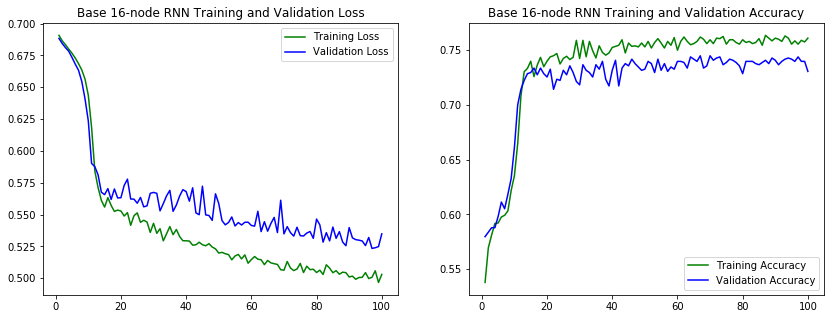

In [33]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['acc']
val_acc = history.history['val_acc']
epochs = range(1, len(train_loss) + 1)
plt.figure(figsize=(14, 5))
plt.subplot(121)
plt.plot(epochs, train_loss, 'g', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Base 16-node RNN Training and Validation Loss')
plt.legend()
plt.subplot(122)
plt.plot(epochs, train_acc, 'g', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
plt.title('Base 16-node RNN Training and Validation Accuracy')
plt.legend()
plt.show()

The model overfits before 20 training epochs but the training accuracy does not improve after 50 epochs. We need to scale up the model.

In [34]:
model.evaluate(X_val, y_val)

 32/980 [..............................] - ETA: 0s

480/980 [=============>................] - ETA: 0s

980/980 [==============================] - 0s 107us/step


[0.5348502852478806, 0.7306122453845277]

The validation accuracy on this simple base model is **73.06**%

In [35]:
y_train_pred = model.predict_classes(X_train)
y_val_pred = model.predict_classes(X_val)

In [36]:
print('train preds = %s\nvalidation preds = %s' % (y_train_pred.shape, y_val_pred.shape))

train preds = (1988, 1)
validation preds = (980, 1)


In [37]:
y_train_pred[:10]

array([[1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0]], dtype=int32)

In [38]:
cf_matrix_train = confusion_matrix(y_train, y_train_pred)
cf_matrix_train

array([[666, 339],
       [171, 812]])

In [39]:
cf_matrix_val = confusion_matrix(y_val, y_val_pred)
cf_matrix_val

array([[314, 165],
       [ 99, 402]])

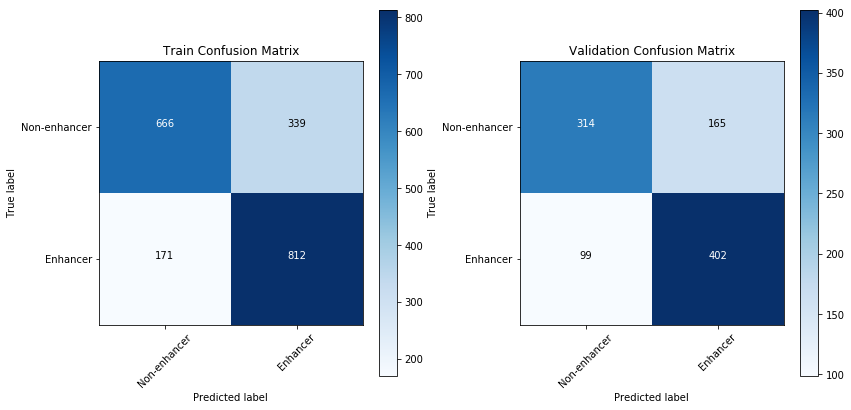

In [40]:
plt.figure(figsize=(12, 6))
plt.subplot(121)
mu.plot_confusion_matrix(cf_matrix_train, classes= ['Non-enhancer', 'Enhancer'], title='Train Confusion Matrix')
plt.subplot(122)
mu.plot_confusion_matrix(cf_matrix_val, classes= ['Non-enhancer', 'Enhancer'], title='Validation Confusion Matrix')
plt.show()

### Scale up the base model

to be continued ...